## Regression of Edmunds Consumer Car Dataset

Dataset Source: https://www.kaggle.com/datasets/ankkur13/edmundsconsumer-car-ratings-and-reviews

#### Import Necessary Libraries

In [1]:
import sys, os, math, random, re, logging
os.environ['TOKENIZERS_PARALLELISM']='false'

import glob

import numpy as np
import pandas as pd

import torch

import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_squared_error, r2_score

from transformers import AutoTokenizer, Trainer, TrainingArguments, AutoModelForSequenceClassification, set_seed, get_scheduler

from datasets import Dataset, DatasetDict

NOTE: Redirects are currently not supported in Windows or MacOs.


#### Display Versions of Relevant Libraries, Frameworks, Languages, etc. Used in This Project

In [2]:
print("Python Version:".rjust(18), sys.version[0:6])
print("NumPy Version:".rjust(18), np.__version__)
print("Pandas Version:".rjust(18), pd.__version__)
print("Torch Version:".rjust(18), torch.__version__)

   Python Version: 3.9.12
    NumPy Version: 1.23.3
   Pandas Version: 1.5.0
    Torch Version: 1.12.1


### Data Ingestion & Preprocessing

#### Data Ingestion

In [3]:
manufacturers_to_keep = ["Buick", "Chevrolet", "chrysler", "dodge", "ford", "GMC", "jeep"]

data_folder = "/Users/briandunn/Documents/nlpnn/Datasets/Car_Reviews"
folder_concat = '/Users/briandunn/Documents/nlpnn/Datasets/Car_Reviews/Scraped_Car_Review_'
files_to_keep = ["Buick", "Chevrolet", "chrysler", "dodge", "ford", "GMC", "jeep"]
file_type=".csv"

all_files = glob.glob(os.path.join(data_folder, "*.csv"))
fileset = [x for x in all_files if x.split("Scraped_Car_Review_")[-1].split(".")[0] in files_to_keep]

df = pd.concat((pd.read_csv(f, on_bad_lines="skip", lineterminator='\n') for f in fileset), ignore_index=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67816 entries, 0 to 67815
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Unnamed: 0     67816 non-null  int64  
 1   Review_Date    67816 non-null  object 
 2   Author_Name    67816 non-null  object 
 3   Vehicle_Title  67816 non-null  object 
 4   Review_Title   67810 non-null  object 
 5   Review         67816 non-null  object 
        67816 non-null  float64
dtypes: float64(1), int64(1), object(5)
memory usage: 3.6+ MB


#### Data Preprocessing (Part 1)

In [4]:
# drop duplicate reviews
df.drop_duplicates(inplace=True)

# Features to drop, if they still are included in the dataframe
cols_to_check = ["Vehicle_Title", "Unnamed: 0", "Review_Date", "Author_Name", "level_0", "index"] 
cols_to_drop = []
for x in cols_to_check:
    if x in df.columns:
        cols_to_drop.append(x)

df.drop(columns=cols_to_drop, inplace=True)

# concatenate the review title and text and rename it to 'text' (use ' : ' as the seperator)
df["text"] = df["Review_Title"] + " : " + df["Review"]

'''
Since there were only 13 missing values (all of them are review titles) 
out of 226,000+ samples in the original dataset, I am just going to drop
those samples. It looks like only five of these missing values were 
from this section of the dataset.
'''
review_title_feature = "Review_Title"
if review_title_feature in df.columns:
    df.dropna(axis=0, subset=[review_title_feature], inplace=True)

df

,Review_Title,Review,Rating\r,text
0,Silverado Success,My '06 Chevy Silverado 1500HD with 6.0 liter ...,4.125,Silverado Success : My '06 Chevy Silverado 15...
1,2006 HD 2500,"I have owned 5 Silverado's since 1999, would ...",4.875,2006 HD 2500 : I have owned 5 Silverado's sin...
2,Love the truck but not the fuel mileage,I am a line driver for a local trucking compa...,4.625,Love the truck but not the fuel mileage : I a...
3,Tow Vehicle,We purchased this thruck to pull a 33 ft Amer...,4.375,Tow Vehicle : We purchased this thruck to pul...
4,1500HD Crew,This has been the best truck I've ever owned....,5.000,1500HD Crew : This has been the best truck I'...
...,...,...,...,...
67811,High Cost of Ownership,By far the most costly vehicle I have \rever ...,3.875,High Cost of Ownership : By far the most cost...
67812,5 for 5,I'm on my 5th Suburban. I love them \rand I ...,5.000,5 for 5 : I'm on my 5th Suburban. I love the...
67813,Dependable,One of the best vechicles I ever \rowned. Ri...,5.000,Dependable : One of the best vechicles I ever...
67814,WHAT A TRUCK,There are a few things to look for when \rbuy...,4.750,WHAT A TRUCK : There are a few things to look...


#### Data Preprocessing (Part 2)

In [5]:
ratings_col = "Rating\r"
if ratings_col in df.columns:
    df["Rating\r"] = df["Rating\r"].astype(float)
    df.rename(columns={"Rating\r" : "label"}, inplace=True)


# Drop Unused Features
cols_to_check = ["Review_Title", "Review"] 
cols_to_drop = []


for x in cols_to_check:
    if np.any(x in df.columns):
        if np.any("text" in df.columns):
            cols_to_drop.append(x)

df.drop(columns=cols_to_drop, inplace=True)

df

,label,text
0,4.125,Silverado Success : My '06 Chevy Silverado 15...
1,4.875,2006 HD 2500 : I have owned 5 Silverado's sin...
2,4.625,Love the truck but not the fuel mileage : I a...
3,4.375,Tow Vehicle : We purchased this thruck to pul...
4,5.000,1500HD Crew : This has been the best truck I'...
...,...,...
67811,3.875,High Cost of Ownership : By far the most cost...
67812,5.000,5 for 5 : I'm on my 5th Suburban. I love the...
67813,5.000,Dependable : One of the best vechicles I ever...
67814,4.750,WHAT A TRUCK : There are a few things to look...


#### Visulatization: Distribution of

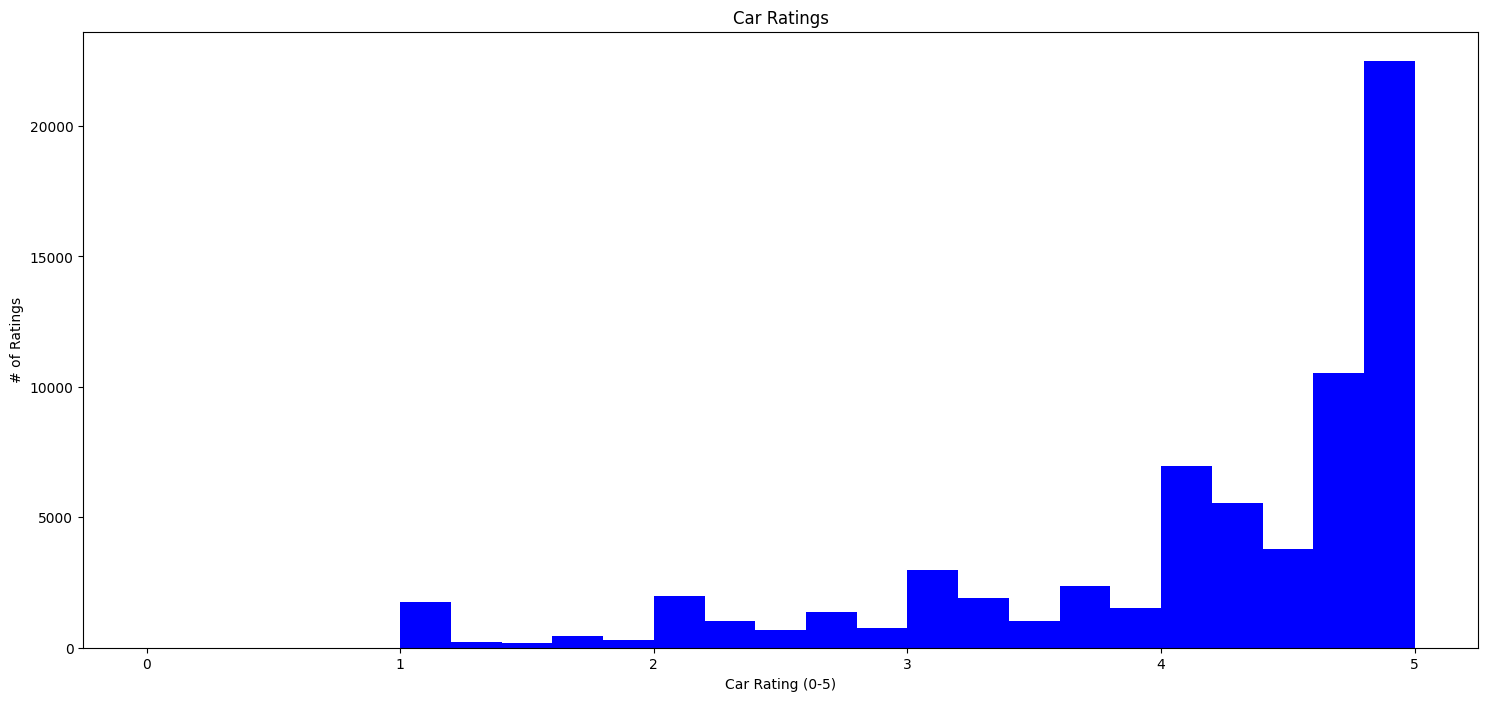

In [6]:
df.hist("label", color="Blue", grid=False, bins=25, figsize=(18,8), range=(0,5))
plt.suptitle('')
plt.title('Car Ratings')
plt.xlabel('Car Rating (0-5)')
plt.ylabel('# of Ratings')
plt.show()

#### Visualiation of Input Length

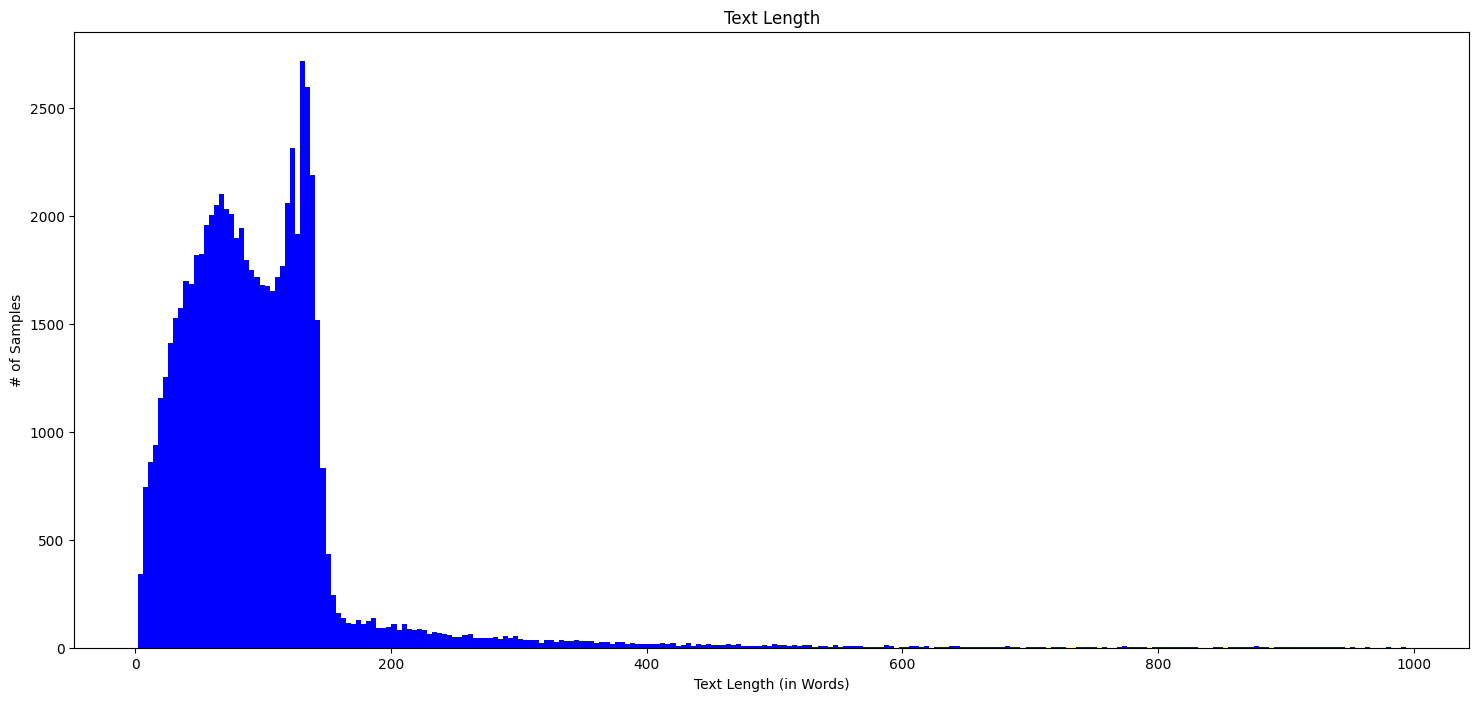

In [7]:
df['Text Length'] = df['text'].str.split().apply(len)

df.hist("Text Length", color="Blue", grid=False, bins=250, figsize=(18,8))
plt.suptitle('')
plt.xlabel('Text Length (in Words)')
plt.ylabel('# of Samples')
plt.show()

#### Drop Unnecessary Features & Trim Overly Lengthy Reviews

In [8]:
df = df[df["Text Length"] < 146]

df.drop(columns=["Text Length"], inplace=True)

df.reset_index(inplace=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62116 entries, 0 to 62115
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   index   62116 non-null  int64  
 1   label   62116 non-null  float64
 2   text    62116 non-null  object 
dtypes: float64(1), int64(1), object(1)
memory usage: 1.4+ MB


/var/folders/93/v_c2ph_17t97zdkzc4_ccjtw0000gn/T/ipykernel_24282/2309865579.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns=["Text Length"], inplace=True)


### Actual Project

#### Convert Pandas DataFrame to Datasets

In [9]:
dataset = Dataset.from_pandas(df)

#### Split Dataset into Training & Testing Dataset

In [10]:
train_testvalid = dataset.train_test_split(test_size=0.20)
test_valid = train_testvalid['test'].train_test_split(test_size=0.50)

ds = DatasetDict({
    'train' : train_testvalid['train'],
    'test' : test_valid['test'],
    'eval' : test_valid['train']
})

print('Training data shape:', ds['train'].shape)
print('Testing data shape:', ds['test'].shape)
print('Eval data shape:', ds['eval'].shape)

Training data shape: (49692, 3)
Testing data shape: (6212, 3)
Eval data shape: (6212, 3)


##### Basic Values

In [11]:
NUM_OF_EPOCHS = 3
MAX_INPUT_LEN = int(round(145*1.3, 0))

MODEL_CKPT = "distilbert-base-uncased"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

NUM_LABELS = 1
BATCH_SIZE = 64

MODEL_NAME = f"{MODEL_CKPT}-Regression-Edmunds_Car_Reviews-American_Made"
LEARNING_RATE = 2e-5

set_seed(42)

#### HuggingFace Access Token & Install git lfs

In [12]:
# HuggingFace Access Token ... 

!git lfs install

Git LFS initialized.


#### Tokenize Entire Dataset

In [13]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_CKPT)

def tokenize(batch):
    return tokenizer(batch['text'], truncation=True, padding=True, max_length=MAX_INPUT_LEN, return_tensors="np")

encoded_ds = ds.map(tokenize, batched=True, batch_size=None)

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

#### Print Example to Ensure Edits Worked As Expected

In [14]:
print(encoded_ds['train'].features)
print(encoded_ds['train'])

{'index': Value(dtype='int64', id=None), 'label': Value(dtype='float64', id=None), 'text': Value(dtype='string', id=None), 'input_ids': Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None), 'attention_mask': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None)}
Dataset({
    features: ['index', 'label', 'text', 'input_ids', 'attention_mask'],
    num_rows: 49692
})


#### Initialize Model

In [15]:
model = (AutoModelForSequenceClassification.from_pretrained(MODEL_CKPT, num_labels=NUM_LABELS)).to(DEVICE)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_projector.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.weight', 'pre_clas

#### Metrics Evaluation Function

In [16]:
def compute_metrics_for_regression(eval_pred):
    logits, labels = eval_pred
    labels = labels.reshape(-1, 1)

    mse = mean_squared_error(labels, logits)
    rmse = mean_squared_error(labels, logits, squared=False)
    mae = mean_absolute_error(labels, logits)
        
    return {"mae": mae, "mse": mse, "rmse": rmse}

#### Trainer Arguments

In [17]:
training_args = TrainingArguments(output_dir=MODEL_NAME, 
                                  num_train_epochs=NUM_OF_EPOCHS, 
                                  per_device_train_batch_size=BATCH_SIZE, 
                                  per_device_eval_batch_size=BATCH_SIZE, 
                                  weight_decay=0.01,
                                  learning_rate=LEARNING_RATE,
                                  no_cuda=True,
                                  evaluation_strategy='epoch',
                                  save_total_limit=10,
                                  logging_strategy='epoch',
                                  load_best_model_at_end=True,
                                  metric_for_best_model='mae',
                                  greater_is_better=False,
                                  save_strategy='epoch',
                                  push_to_hub=True)

####  Build Trainer

In [18]:
trainer = Trainer(model=model, 
                  args=training_args, 
                  train_dataset=encoded_ds['train'], 
                  eval_dataset=encoded_ds['eval'],
                  tokenizer=tokenizer,
                  compute_metrics=compute_metrics_for_regression)

/Users/briandunn/Documents/nlpnn/nlp_ml/lib/python3.9/site-packages/huggingface_hub/repository.py:705: FutureWarning: Creating a repository through 'clone_from' is deprecated and will be removed in v0.11.
  warnings.warn(
Cloning https://huggingface.co/DunnBC22/distilbert-base-uncased-Regression-Edmunds_Car_Reviews-American_Made into local empty directory.


#### Train Trainer

In [19]:
trainer.train()

The following columns in the training set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: index, text. If index, text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
/Users/briandunn/Documents/nlpnn/nlp_ml/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 49692
  Num Epochs = 3
  Instantaneous batch size per device = 64
  Total train batch size (w. parallel, distributed & accumulation) = 64
  Gradient Accumulation steps = 1
  Total optimization steps = 2331


A Jupyter Widget

You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: index, text. If index, text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 6212
  Batch size = 64


{'loss': 0.6385, 'learning_rate': 1.3333333333333333e-05, 'epoch': 1.0}


A Jupyter Widget

Saving model checkpoint to distilbert-base-uncased-Regression-Edmunds_Car_Reviews-American_Made/checkpoint-777
Configuration saved in distilbert-base-uncased-Regression-Edmunds_Car_Reviews-American_Made/checkpoint-777/config.json
Model weights saved in distilbert-base-uncased-Regression-Edmunds_Car_Reviews-American_Made/checkpoint-777/pytorch_model.bin
tokenizer config file saved in distilbert-base-uncased-Regression-Edmunds_Car_Reviews-American_Made/checkpoint-777/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-Regression-Edmunds_Car_Reviews-American_Made/checkpoint-777/special_tokens_map.json


{'eval_loss': 0.27426889538764954, 'eval_mae': 0.3632640838623047, 'eval_mse': 0.27426889538764954, 'eval_rmse': 0.52370685338974, 'eval_runtime': 2556.7497, 'eval_samples_per_second': 2.43, 'eval_steps_per_second': 0.038, 'epoch': 1.0}


tokenizer config file saved in distilbert-base-uncased-Regression-Edmunds_Car_Reviews-American_Made/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-Regression-Edmunds_Car_Reviews-American_Made/special_tokens_map.json
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: index, text. If index, text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 6212
  Batch size = 64


{'loss': 0.2551, 'learning_rate': 6.666666666666667e-06, 'epoch': 2.0}


A Jupyter Widget

Saving model checkpoint to distilbert-base-uncased-Regression-Edmunds_Car_Reviews-American_Made/checkpoint-1554
Configuration saved in distilbert-base-uncased-Regression-Edmunds_Car_Reviews-American_Made/checkpoint-1554/config.json
Model weights saved in distilbert-base-uncased-Regression-Edmunds_Car_Reviews-American_Made/checkpoint-1554/pytorch_model.bin
tokenizer config file saved in distilbert-base-uncased-Regression-Edmunds_Car_Reviews-American_Made/checkpoint-1554/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-Regression-Edmunds_Car_Reviews-American_Made/checkpoint-1554/special_tokens_map.json


{'eval_loss': 0.258842796087265, 'eval_mae': 0.35361719131469727, 'eval_mse': 0.258842796087265, 'eval_rmse': 0.5087659358978271, 'eval_runtime': 2561.4417, 'eval_samples_per_second': 2.425, 'eval_steps_per_second': 0.038, 'epoch': 2.0}


tokenizer config file saved in distilbert-base-uncased-Regression-Edmunds_Car_Reviews-American_Made/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-Regression-Edmunds_Car_Reviews-American_Made/special_tokens_map.json
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: index, text. If index, text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 6212
  Batch size = 64


{'loss': 0.2161, 'learning_rate': 0.0, 'epoch': 3.0}


A Jupyter Widget

Saving model checkpoint to distilbert-base-uncased-Regression-Edmunds_Car_Reviews-American_Made/checkpoint-2331
Configuration saved in distilbert-base-uncased-Regression-Edmunds_Car_Reviews-American_Made/checkpoint-2331/config.json
Model weights saved in distilbert-base-uncased-Regression-Edmunds_Car_Reviews-American_Made/checkpoint-2331/pytorch_model.bin
tokenizer config file saved in distilbert-base-uncased-Regression-Edmunds_Car_Reviews-American_Made/checkpoint-2331/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-Regression-Edmunds_Car_Reviews-American_Made/checkpoint-2331/special_tokens_map.json


{'eval_loss': 0.2568396031856537, 'eval_mae': 0.3508163094520569, 'eval_mse': 0.2568396031856537, 'eval_rmse': 0.5067934393882751, 'eval_runtime': 2592.1727, 'eval_samples_per_second': 2.396, 'eval_steps_per_second': 0.038, 'epoch': 3.0}


tokenizer config file saved in distilbert-base-uncased-Regression-Edmunds_Car_Reviews-American_Made/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-Regression-Edmunds_Car_Reviews-American_Made/special_tokens_map.json


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from distilbert-base-uncased-Regression-Edmunds_Car_Reviews-American_Made/checkpoint-2331 (score: 0.3508163094520569).


{'train_runtime': 192500.2453, 'train_samples_per_second': 0.774, 'train_steps_per_second': 0.012, 'train_loss': 0.3699031847835559, 'epoch': 3.0}


TrainOutput(global_step=2331, training_loss=0.3699031847835559, metrics={'train_runtime': 192500.2453, 'train_samples_per_second': 0.774, 'train_steps_per_second': 0.012, 'train_loss': 0.3699031847835559, 'epoch': 3.0})

### Evaluate Model

#### Generate Predictions

In [20]:
trainer.eval_dataset = encoded_ds['test']
trainer.evaluate()

The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: index, text. If index, text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 6212
  Batch size = 64


A Jupyter Widget

{'eval_loss': 0.24857571721076965,
 'eval_mae': 0.3469300866127014,
 'eval_mse': 0.24857571721076965,
 'eval_rmse': 0.4985736906528473,
 'eval_runtime': 2585.0899,
 'eval_samples_per_second': 2.403,
 'eval_steps_per_second': 0.038,
 'epoch': 3.0}

#### Push Model to Hub

In [21]:
trainer.push_to_hub(commit_message="All Dunn!!!")

Saving model checkpoint to distilbert-base-uncased-Regression-Edmunds_Car_Reviews-American_Made
Configuration saved in distilbert-base-uncased-Regression-Edmunds_Car_Reviews-American_Made/config.json
Model weights saved in distilbert-base-uncased-Regression-Edmunds_Car_Reviews-American_Made/pytorch_model.bin
tokenizer config file saved in distilbert-base-uncased-Regression-Edmunds_Car_Reviews-American_Made/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-Regression-Edmunds_Car_Reviews-American_Made/special_tokens_map.json
Dropping the following result as it does not have all the necessary fields:
{'task': {'name': 'Text Classification', 'type': 'text-classification'}}
To https://huggingface.co/DunnBC22/distilbert-base-uncased-Regression-Edmunds_Car_Reviews-American_Made
   356c506..bd4e410  main -> main



### Notes & Other Takeaways From This Project
****
- I was able to use the insight that I gleaned from the European Automobile version of this regression analysis to lower the necessary number of epochs from 5 to 3.
****
- The results are disappointing. I was hoping for it to be less than a fifth of a point in Mean Absolute Error (MAE). Instead it was about seventy-five percent (75%) higher, with an MAE of about 0.35.
****